In [ ]:
import pandas as pd
import nltk
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification

c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train = pd.read_table(
    "../datasets/CREMA-D/text/train.txt",
    delimiter=";",
    header=None,
)

val = pd.read_table(
    "../datasets/CREMA-D/text/val.txt",
    delimiter=";",
    header=None,
)

test = pd.read_table(
    "../datasets/CREMA-D/text/test.txt",
    delimiter=";",
    header=None,
)

train.columns = ["Text", "Emotion"]
val.columns = ["Text", "Emotion"]
test.columns = ["Text", "Emotion"]

# print("Train head:", train.head())
# print("Train shape:", train.shape)
# print("-" * 10)
# print("Val head:", val.head())
# print("Val shape:", val.shape)
# print("-" * 10)
# print("Test head:", test.head())
# print("Test shape:", test.shape)
# print("-" * 10)

data = pd.concat([train, val, test], ignore_index=True)
data.columns = ["text", "label"]

# print("Data head:", data.head())
print("Data shape:", data.shape)

Data shape: (20000, 2)


In [4]:
data.isna().any(axis=1).sum()

0

In [ ]:
nltk.download("stopwords")

import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


def preprocess(line):
    review = re.sub("[^a-zA-Z]", " ", line)
    review = review.lower()
    review = review.split()

    # apply Stemming + remove the stopwords
    review = [
        PorterStemmer().stem(word)
        for word in review
        if not word in stopwords.words("english")
    ]

    return " ".join(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:


# Preprocess training, validation, and test datasets
train["text"] = train["Text"].apply(lambda x: preprocess(x))
val["text"] = val["Text"].apply(lambda x: preprocess(x))
test["text"] = test["Text"].apply(lambda x: preprocess(x))

# Encode labels for training, validation, and test sets
label_encoder = preprocessing.LabelEncoder()
train["N_label"] = label_encoder.fit_transform(train["Emotion"])
val["N_label"] = label_encoder.transform(val["Emotion"])  # Use the same encoder
test["N_label"] = label_encoder.transform(test["Emotion"])  # Use the same encoder


Epoch 1/10
500/500 [==============================] - 13s 23ms/step - loss: 1.1343 - accuracy: 0.5515 - val_loss: 0.6217 - val_accuracy: 0.7310
Epoch 2/10
500/500 [==============================] - 11s 22ms/step - loss: 0.4721 - accuracy: 0.8202 - val_loss: 0.3597 - val_accuracy: 0.8865
Epoch 3/10
500/500 [==============================] - 11s 22ms/step - loss: 0.2828 - accuracy: 0.9029 - val_loss: 0.3417 - val_accuracy: 0.8855
Epoch 4/10
500/500 [==============================] - 11s 23ms/step - loss: 0.2047 - accuracy: 0.9300 - val_loss: 0.3811 - val_accuracy: 0.8825
Epoch 5/10
500/500 [==============================] - 11s 23ms/step - loss: 0.1581 - accuracy: 0.9457 - val_loss: 0.4126 - val_accuracy: 0.8805
Epoch 6/10
500/500 [==============================] - 11s 22ms/step - loss: 0.1274 - accuracy: 0.9569 - val_loss: 0.4454 - val_accuracy: 0.8770
Epoch 7/10
500/500 [==============================] - 11s 23ms/step - loss: 0.1069 - accuracy: 0.9640 - val_loss: 0.4697 - val_accuracy:

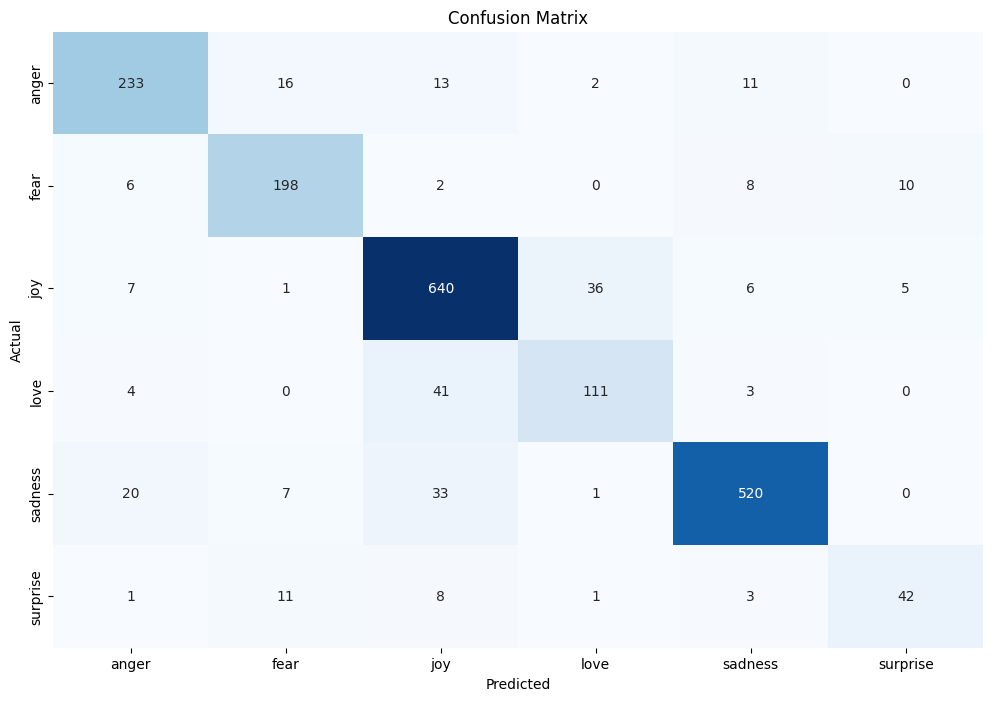

              precision    recall  f1-score   support

       anger       0.86      0.85      0.85       275
        fear       0.85      0.88      0.87       224
         joy       0.87      0.92      0.89       695
        love       0.74      0.70      0.72       159
     sadness       0.94      0.90      0.92       581
    surprise       0.74      0.64      0.68        66

    accuracy                           0.87      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.87      0.87      0.87      2000



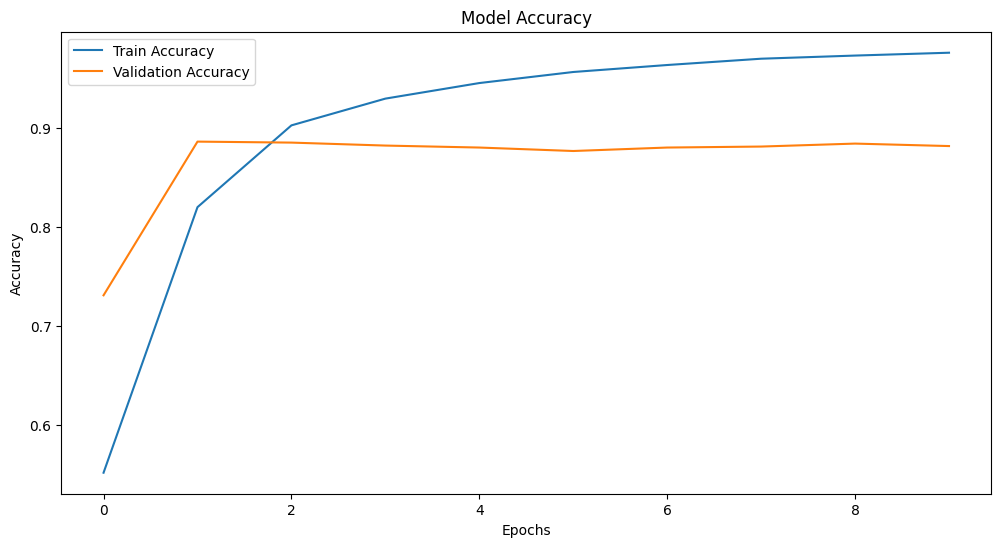

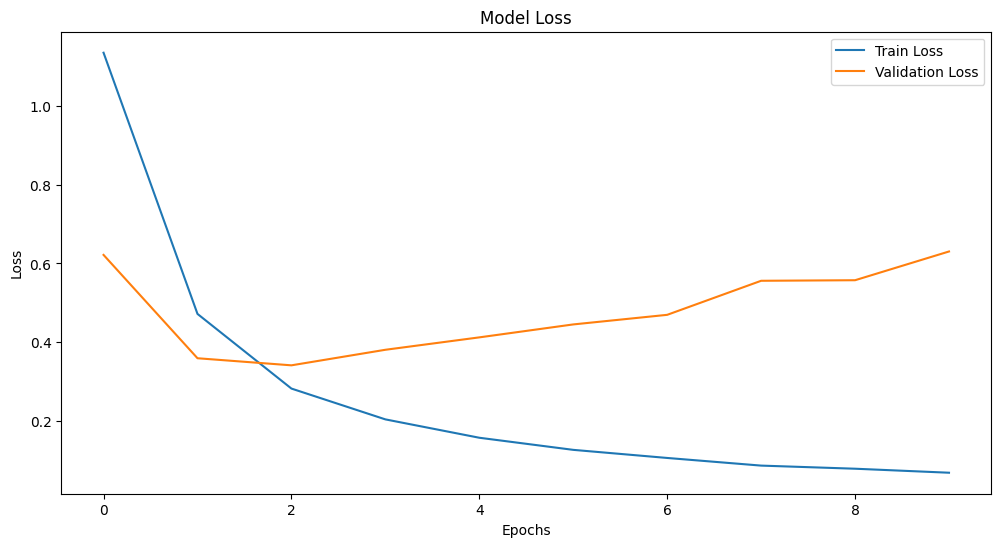

In [ ]:


# Tokenize and pad sequences
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=5000)  # Use the top 5000 words
tokenizer.fit_on_texts(train["text"])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train["text"])
X_val = tokenizer.texts_to_sequences(val["text"])
X_test = tokenizer.texts_to_sequences(test["text"])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(train["N_label"])
y_val = np.array(val["N_label"])
y_test = np.array(test["N_label"])

# Build the CNN model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# Convolutional layers
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predict on the test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 [==============================] - 0s 5ms/step - loss: 0.5667 - accuracy: 0.8720
Test Accuracy: 87.20%


Model: "Text_Emotion_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 128)          32896     
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)           

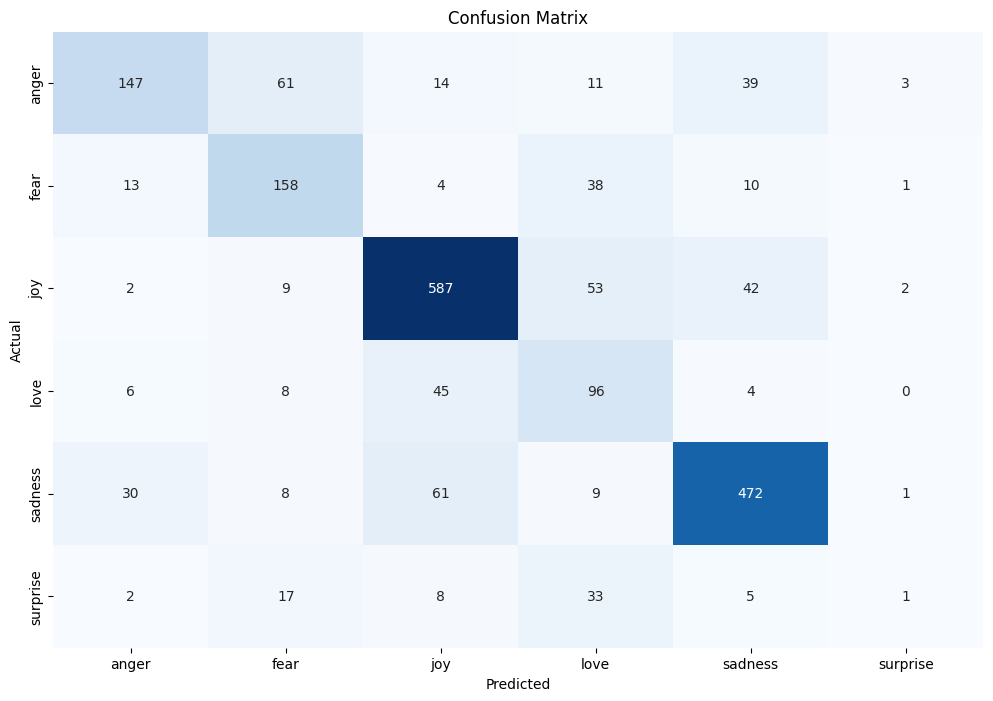

              precision    recall  f1-score   support

       anger       0.73      0.53      0.62       275
        fear       0.61      0.71      0.65       224
         joy       0.82      0.84      0.83       695
        love       0.40      0.60      0.48       159
     sadness       0.83      0.81      0.82       581
    surprise       0.12      0.02      0.03        66

    accuracy                           0.73      2000
   macro avg       0.58      0.59      0.57      2000
weighted avg       0.73      0.73      0.72      2000



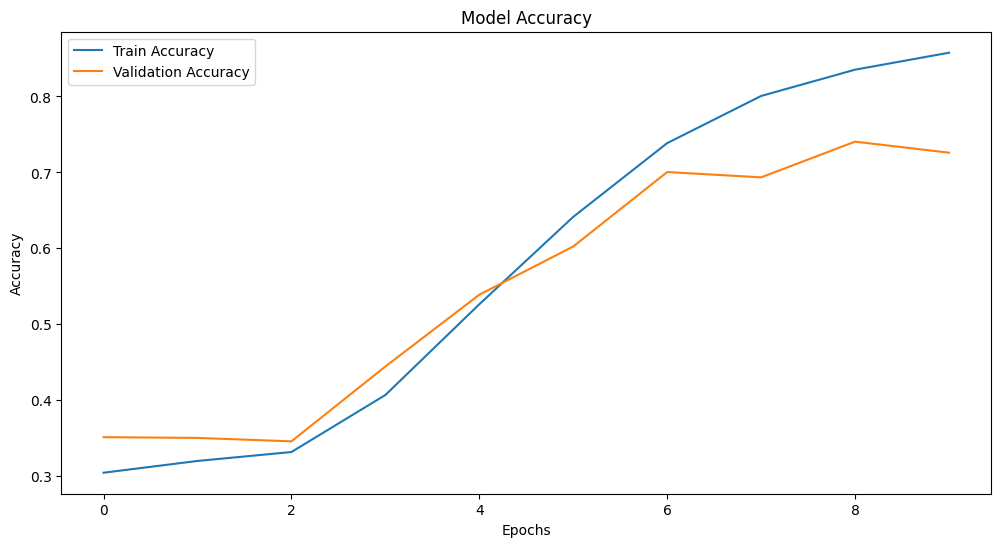

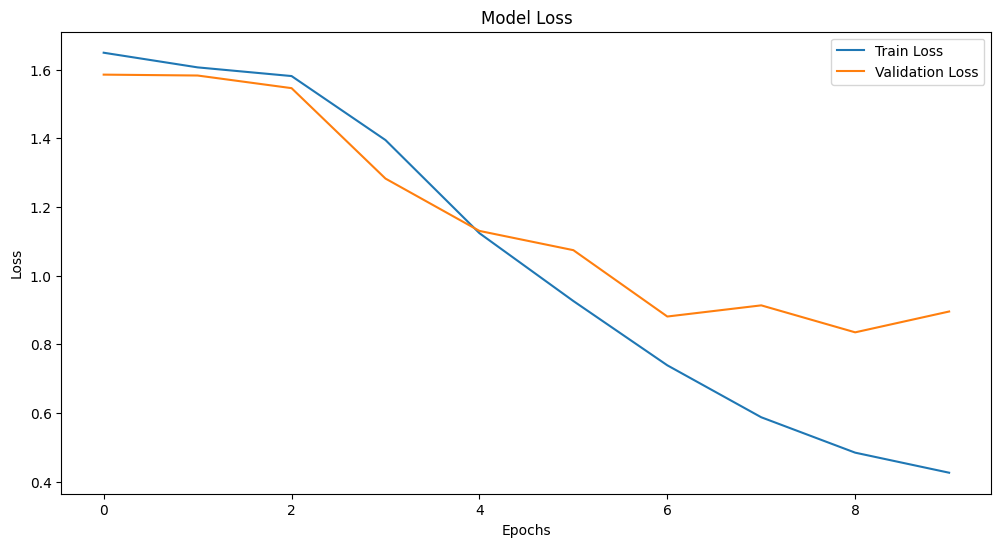

In [5]:


# Build the RNN-based model
model = Sequential(name="Text_Emotion_RNN")

# Embedding Layer
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# RNN Layers
model.add(SimpleRNN(128, return_sequences=True, activation="tanh"))
model.add(Dropout(0.3))
model.add(SimpleRNN(64, activation="tanh"))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation="softmax"))

# Compile the Model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Model Summary
model.summary()

# Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on Test Data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")